In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_11296\1557460481.py:13: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


In [11]:
data=pd.read_csv("levelups_panel_20240722.csv",encoding='utf-8')
data = data[data['level_to'] <= 100]

## Ads Data

In [15]:
data_ratio_term = data[['player_slug','binge', 'level_to', 'interval','total_purchase','total_ad']]

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data.drop_duplicates('player_slug').set_index('player_slug')[['total_ad','total_purchase']]
pivot_data_ratio = pivot_data_ratio.join(binge_series)

In [16]:
pivot_data_ratio

,2,3,4,5,6,7,8,9,10,11,...,93,94,95,96,97,98,99,100,total_ad,total_purchase
player_slug,,,,,,,,,,,,,,,,,,,,,
2021-10-31T16:01:57.631Z,0.009444,0.008222,0.026389,0.018278,0.052222,0.020833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2021-10-31T23:13:52.512Z,0.014444,0.008611,0.018889,0.019722,0.032500,0.025278,0.026667,0.035000,0.040833,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2021-11-01T00:29:22.357Z,0.016944,0.004722,0.008889,0.016389,0.018611,0.020833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2021-11-01T03:34:17.980Z,0.012500,0.012778,0.018333,0.014444,0.033889,0.023056,0.025556,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2021-11-01T05:12:15.383Z,0.024722,0.011389,0.035833,0.029000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30T13:53:30.032Z,0.011111,0.003889,0.010278,0.015833,0.043333,0.022222,0.023889,0.029722,0.033889,0.042778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2022-03-30T14:09:03.502Z,0.009167,0.009444,0.028333,0.028889,0.025278,0.024444,0.025000,0.031389,0.043056,0.047500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2022-03-30T14:13:23.546Z,0.009167,0.006389,0.009167,0.018056,0.015833,0.028889,0.020833,0.031667,0.036111,0.042500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [17]:
filtered_df = pivot_data_ratio.dropna(subset=pivot_data_ratio.columns[:100])
non_zero_ad_total_count = filtered_df[(filtered_df['total_ad'] != 0) & (filtered_df['total_purchase'] != 0)].shape[0]
non_zero_ad_total_count

1104

In [18]:
filtered_df

,2,3,4,5,6,7,8,9,10,11,...,93,94,95,96,97,98,99,100,total_ad,total_purchase
player_slug,,,,,,,,,,,,,,,,,,,,,
2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,0.059167,...,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0,0.0
2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,0.041667,...,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,28.0,0.0
2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,0.041944,...,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0,0.0
2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,0.042222,...,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0,0.0
2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,0.036667,...,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,2.0,3300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,0.047500,...,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,2.0,3300.0
2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,0.037778,...,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0,0.0
2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,0.050833,...,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,0.0,122100.0


In [19]:
# 각 컬럼별 null 값의 개수 계산
null_counts = pivot_data_ratio.isnull().sum()

# null 값의 개수를 데이터프레임으로 변환
null_counts_df = null_counts.to_frame('Null Count')

# null 값의 개수를 출력
print(null_counts_df)


                Null Count
2                        0
3                      704
4                     1371
5                     1901
6                     8438
...                    ...
98                   51414
99                   51734
100                  52063
total_ad                 0
total_purchase           0

[101 rows x 1 columns]


In [20]:
filtered_df.to_csv("full_lv100_0801_ad.csv",encoding='utf-8')

In [271]:
data=pd.read_csv("full_lv100_0801_ad.csv",encoding='utf-8')

In [272]:
data['total_ad_to_purchase']=data['total_ad']*3

In [273]:
# 'total'이라는 새로운 컬럼을 추가하여 'total_ad'와 'total_purchase'의 합을 계산
data['total_amount'] = data['total_ad_to_purchase'] + data['total_purchase']


In [274]:
'''
from sklearn.preprocessing import StandardScaler
# StandardScaler를 사용하여 정규화
scaler = StandardScaler()
data['total_ad_normalized'] = scaler.fit_transform(data[['total_ad']])
scaler_purchase = StandardScaler()
data['total_purchase_normalized'] = scaler_purchase.fit_transform(data[['total_purchase']])


'''


"\nfrom sklearn.preprocessing import StandardScaler\n# StandardScaler를 사용하여 정규화\nscaler = StandardScaler()\ndata['total_ad_normalized'] = scaler.fit_transform(data[['total_ad']])\nscaler_purchase = StandardScaler()\ndata['total_purchase_normalized'] = scaler_purchase.fit_transform(data[['total_purchase']])\n\n\n"

In [145]:
# 'total_ad'와 'total_purchase' 열을 데이터프레임에서 삭제
data = data.drop(columns=['total_ad', 'total_purchase','total_ad_to_purchase'])


In [146]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,total_amount
0,2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,...,0.069722,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0
1,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,84.0
2,2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,...,0.046111,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0
3,2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,...,0.077222,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0
4,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,3306.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,3306.0
7275,2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,...,0.127722,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0
7276,2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,...,0.040778,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,122100.0
7277,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.028611,0.007778,0.046389,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,18.0


In [78]:
data.to_csv("full_lv100_0801_total_amount.csv",encoding='utf-8',index=False)

In [340]:
data=pd.read_csv("full_lv100_0801_total_amount.csv",encoding='utf-8')

In [341]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,total_amount
0,2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,...,0.069722,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0
1,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,84.0
2,2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,...,0.046111,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0
3,2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,...,0.077222,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0
4,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,3306.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,3306.0
7275,2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,...,0.127722,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0
7276,2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,...,0.040778,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,122100.0
7277,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.028611,0.007778,0.046389,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,18.0


In [370]:
non_zero_ad_total_count = data[(data['total_amount'] <= 3000)].shape[0]
non_zero_ad_total_count

5621

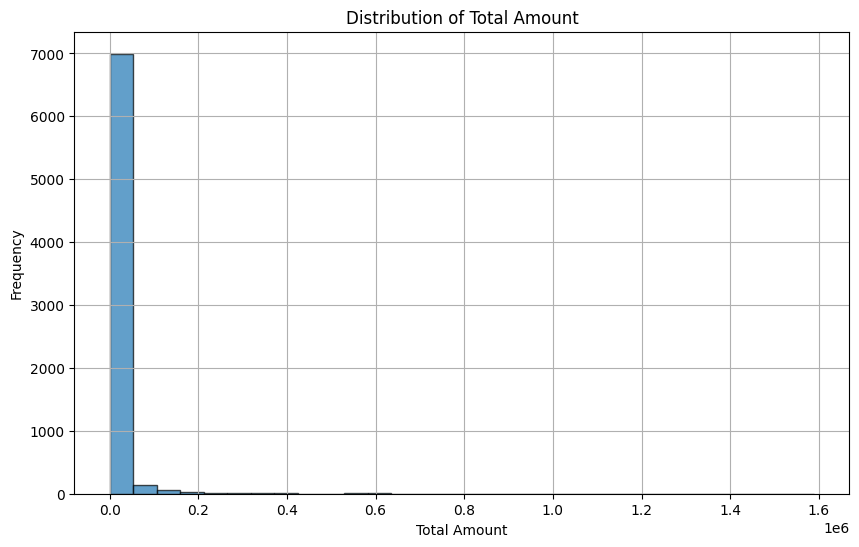

In [342]:
# 'total_amount' 열의 분포도 시각화
plt.figure(figsize=(10, 6))
plt.hist(data['total_amount'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Total Amount')
plt.grid(True)
plt.show()

In [364]:
data['total_amount'].max()

1589500.0

In [343]:
from sklearn.preprocessing import StandardScaler
# total_purchase가 포함된 행만 선택
data = data.drop(columns=['player_slug'])

# X (타임라인 데이터)와 y (total_purchase) 분리
y = data['total_amount'].values
X = data.drop(columns=['total_amount'])
# 함수형 데이터 객체 생성
argvals = np.arange(X.shape[1])
fd = FDataGrid(data_matrix=X.values, grid_points=argvals)

# 데이터 스케일링 및 B-spline 기반 스무딩
scaler = StandardScaler()
basis = BSplineBasis(n_basis=20)
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)



In [352]:
# FPCA 적용
fpca = FPCA(n_components=3)
fd_fpca = fpca.fit_transform(fd_smooth)

# 주성분 설명 분산
explained_variance = fpca.explained_variance_ratio_
print("Explained variance ratio by each component:", explained_variance)


Explained variance ratio by each component: [0.84282735 0.13823412 0.01506863]


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_11296\1393504723.py:3: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the functional data object instead.
  plt.plot(argvals, fpca.components_[i].evaluate(argvals)[0], label=f'Principal Component {i+1}')


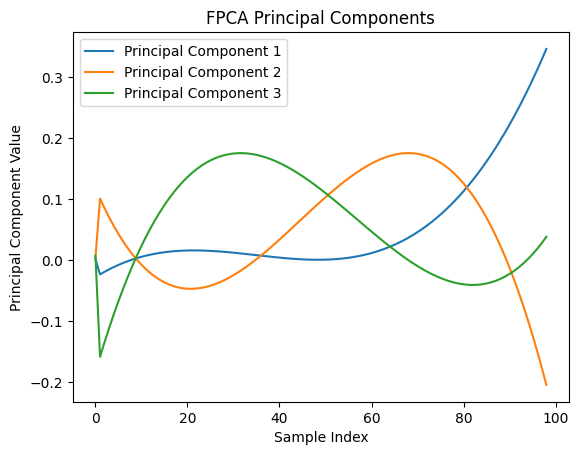

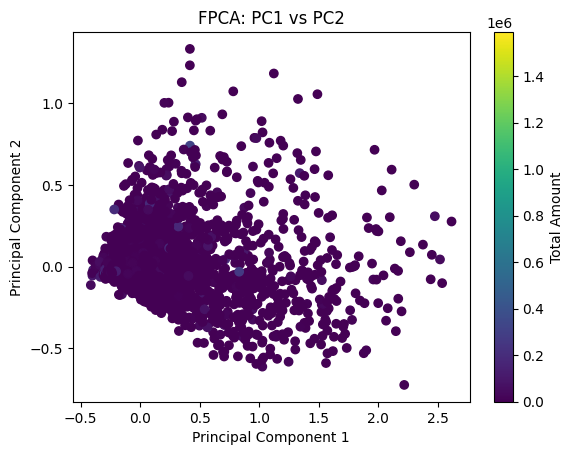

In [363]:
# 주성분 시각화
for i in range(3):
    plt.plot(argvals, fpca.components_[i].evaluate(argvals)[0], label=f'Principal Component {i+1}')

plt.xlabel('Sample Index')
plt.ylabel('Principal Component Value')
plt.title('FPCA Principal Components')
plt.legend()
plt.show()



# 주성분 점수 플롯
plt.scatter(fd_fpca[:, 0], fd_fpca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('FPCA: PC1 vs PC2')
plt.colorbar(label='Total Amount')
plt.show()


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


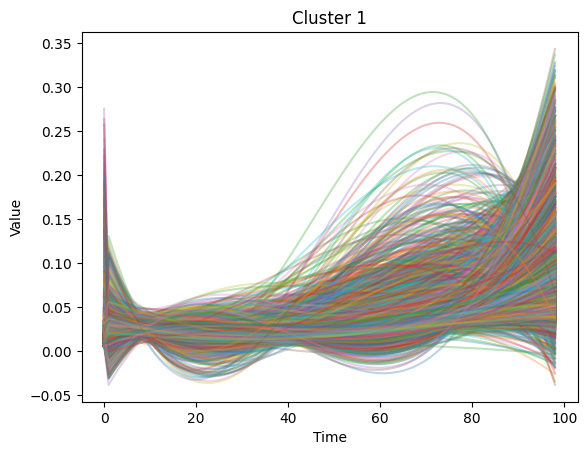

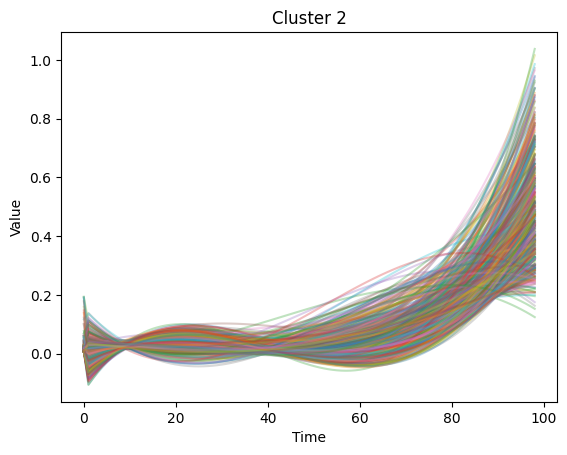

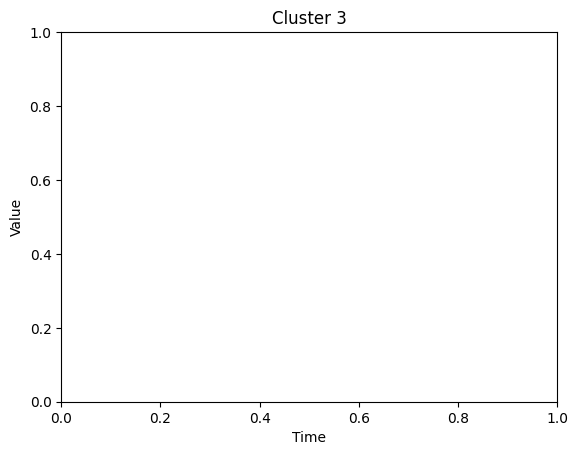

Cluster labels: [0 0 0 ... 0 0 0]


In [371]:

# 함수형 K-평균 클러스터링 수행
kmeans = KMeans(n_clusters=2, random_state=123)
labels = kmeans.fit_predict(fd_fpca)

# 클러스터링 결과 시각화
for i in range(3):
    cluster_indices = np.where(labels == i)[0]
    plt.figure()
    for index in cluster_indices:
        plt.plot(argvals, fd_smooth.data_matrix[index].flatten(), alpha=0.3)
    plt.title(f'Cluster {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

# 클러스터 할당 결과 확인
print("Cluster labels:", labels)

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\

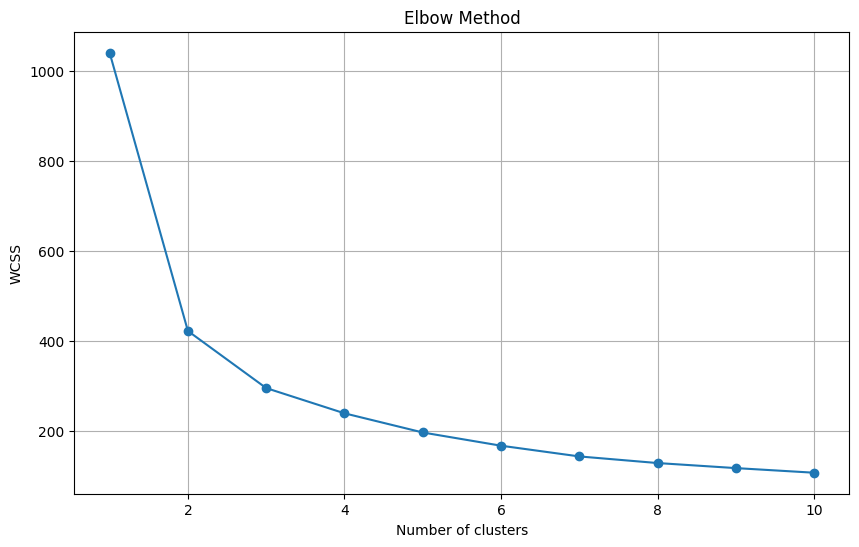

In [354]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# 데이터 생성 또는 로드
# 예: data = your_data

wcss = []

# 1에서 10까지의 K 값에 대해 WCSS 계산
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(fd_fpca)
    wcss.append(kmeans.inertia_)

# 엘보우 방법 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\

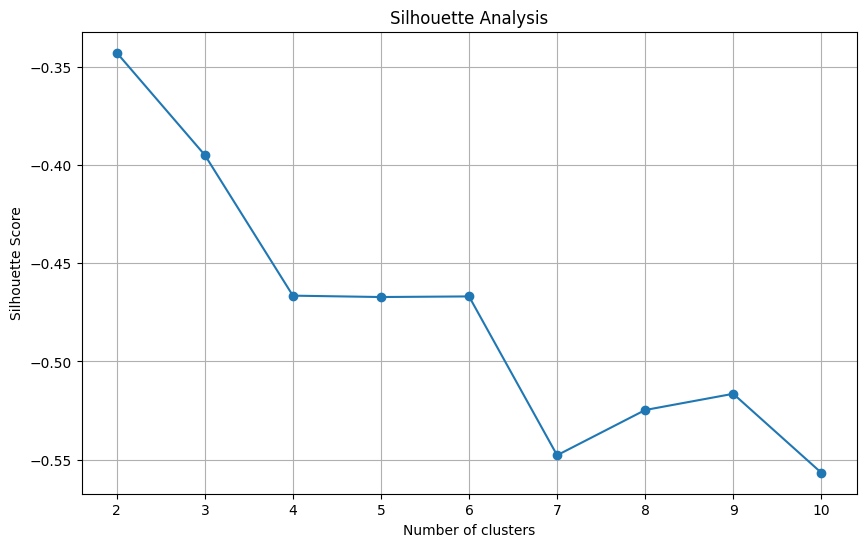

Optimal number of clusters: 2


In [355]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 데이터 생성 또는 로드
# 예: data = your_data

silhouette_scores = []

# 2에서 10까지의 K 값에 대해 실루엣 점수를 계산
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(fd_fpca)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 최적의 K 값 찾기
optimal_k = np.argmax(silhouette_scores) + 2  # +2는 range(2, 11)에서 인덱스를 K 값으로 맞추기 위해

# 실루엣 점수 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

print(f'Optimal number of clusters: {optimal_k}')


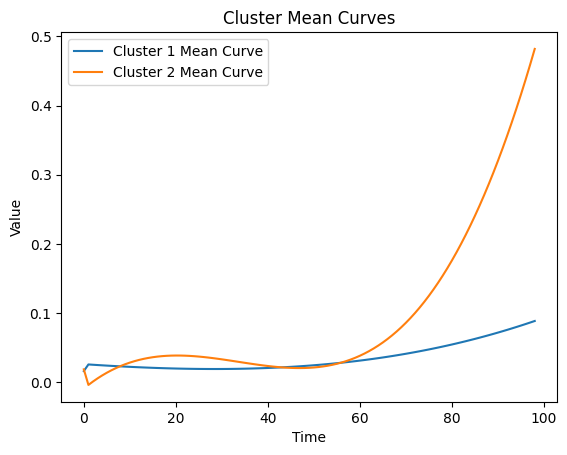

In [372]:
# 클러스터별 평균 곡선 계산 및 시각화
for i in range(2):
    cluster_indices = np.where(labels == i)[0]
    cluster_data = fd_smooth.data_matrix[cluster_indices]
    mean_curve = np.mean(cluster_data, axis=0).flatten()
    plt.plot(argvals, mean_curve, label=f'Cluster {i + 1} Mean Curve')
plt.title('Cluster Mean Curves')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [358]:
# FPCA 주성분을 DataFrame으로 변환
fpca_df = pd.DataFrame(fd_fpca, columns=[f'PC{i+1}' for i in range(fd_fpca.shape[1])])


In [359]:
fpca_df

,PC1,PC2,PC3
0,0.425908,-0.242798,0.072586
1,0.120193,-0.161894,0.002973
2,-0.126732,-0.008908,0.002590
3,-0.085340,-0.025698,0.007323
4,-0.033797,0.093482,0.037043
...,...,...,...
7274,-0.009962,-0.056213,0.040077
7275,0.792481,0.206499,-0.105451
7276,-0.201795,-0.028781,0.011607
7277,-0.239918,-0.030032,-0.027785


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              4.488
Date:                Thu, 01 Aug 2024   Prob (F-statistic):                     0.00376
Time:                        15:38:34   Log-Likelihood:                         -7530.3
No. Observations:                5095   AIC:                                  1.507e+04
Df Residuals:                    5092   BIC:                                  1.509e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

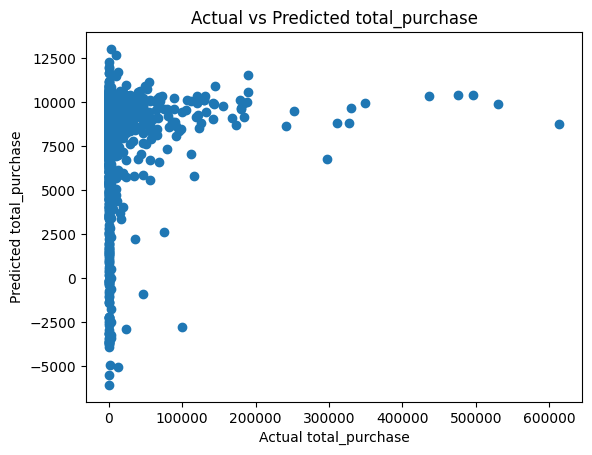

In [373]:
# 데이터 분할 (훈련/테스트)
from sklearn.metrics import r2_score

# total_purchase 값을 기준으로 stratify 배열 생성
#y_stratify = (y > 0).astype(int)


y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# 데이터 분할 (훈련/테스트)
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(fd_fpca, y_scaled, test_size=0.3, random_state=110)

# OLS 모델 적합
model = OLS(y_train_scaled, X_train).fit()

# 모델 요약 출력
print(model.summary())


# 테스트 데이터 예측
y_pred_scaled = model.predict(X_test)

# 예측값 역변환
y_pred = y_scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
y_test = y_scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1)).flatten()
# 예측값이 0보다 작지 않도록 조정
#y_pred = np.maximum(y_pred, 0)

# R-squared 값 계산
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

# 결과 시각화
plt.scatter(y_test, y_pred)
plt.xlabel("Actual total_purchase")
plt.ylabel("Predicted total_purchase")
plt.title("Actual vs Predicted total_purchase")
plt.show()

In [374]:
# R-squared 계산
r_squared = r2_score(y_test, y_pred)

# Adjusted R-squared 계산
n = len(y_test)  # 데이터 포인트의 수
p = X_test.shape[1]  # 독립 변수의 수

adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)


In [375]:
adjusted_r_squared

0.0019613068960129265

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              2.824
Date:                Thu, 01 Aug 2024   Prob (F-statistic):                     0.00958
Time:                        14:38:13   Log-Likelihood:                         -7528.6
No. Observations:                5095   AIC:                                  1.507e+04
Df Residuals:                    5089   BIC:                                  1.511e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

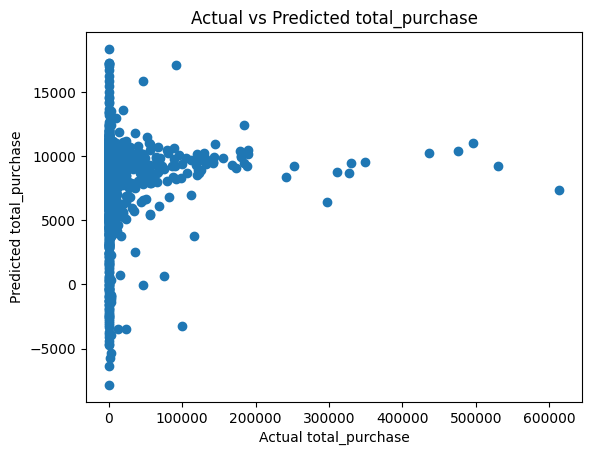

In [270]:
# 데이터 분할 (훈련/테스트)
from sklearn.metrics import r2_score

# total_purchase 값을 기준으로 stratify 배열 생성
#y_stratify = (y > 0).astype(int)

# 원본 데이터의 1차 도함수 계산
fd_deriv = fd_smooth.derivative(order=1)

# FPCA 적용 (미분된 데이터)
fpca_deriv_components = fpca.fit_transform(fd_deriv)

# 주성분과 미분값을 결합
X_fpca_combined = np.hstack([fd_fpca, fpca_deriv_components])


y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# 데이터 분할 (훈련/테스트)
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(X_fpca_combined, y_scaled, test_size=0.3, random_state=110)

# OLS 모델 적합
model = OLS(y_train_scaled, X_train).fit()

# 모델 요약 출력
print(model.summary())


# 테스트 데이터 예측
y_pred_scaled = model.predict(X_test)

# 예측값 역변환
y_pred = y_scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
y_test = y_scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1)).flatten()
# 예측값이 0보다 작지 않도록 조정
#y_pred = np.maximum(y_pred, 0)

# R-squared 값 계산
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

# 결과 시각화
plt.scatter(y_test, y_pred)
plt.xlabel("Actual total_purchase")
plt.ylabel("Predicted total_purchase")
plt.title("Actual vs Predicted total_purchase")
plt.show()

## Plot Ads vs Non Ads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split


In [2]:
df= pd.read_csv('full_lv100_0801_total_amount.csv',encoding='utf-8')

In [3]:
df

,player_slug,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,total_amount
0,2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,...,0.069722,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0
1,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,84.0
2,2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,...,0.046111,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0
3,2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,...,0.077222,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0
4,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,3306.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,3306.0
7275,2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,...,0.127722,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0
7276,2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,...,0.040778,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,122100.0
7277,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.028611,0.007778,0.046389,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,18.0


In [4]:
pivot_data_reset = df.melt(id_vars=['player_slug','total_amount'], var_name='level_to', value_name='interval')
pivot_data_reset

,player_slug,total_amount,level_to,interval
0,2021-11-01T08:32:01.518Z,0.0,2,0.019444
1,2021-11-01T10:41:53.949Z,84.0,2,0.020556
2,2021-11-01T14:12:34.729Z,0.0,2,0.015833
3,2021-11-01T15:01:02.831Z,0.0,2,0.007778
4,2021-11-01T15:10:02.121Z,3306.0,2,0.006944
...,...,...,...,...
720616,2022-03-28T00:01:33.666Z,3306.0,100,0.600833
720617,2022-03-28T07:44:40.201Z,0.0,100,0.067500
720618,2022-03-28T11:06:23.113Z,122100.0,100,0.149722
720619,2022-03-29T09:29:33.653Z,18.0,100,0.102778


In [5]:
# 'color' 열 추가, 'total_ad'와 'total_purchase' 모두 0일 경우 'blue', 아니면 'red'
pivot_data_reset['color'] = pivot_data_reset.apply(lambda row: 'blue' if row['total_amount'] == 0 else 'red', axis=1)


In [6]:
pivot_data_reset

,player_slug,total_amount,level_to,interval,color
0,2021-11-01T08:32:01.518Z,0.0,2,0.019444,blue
1,2021-11-01T10:41:53.949Z,84.0,2,0.020556,red
2,2021-11-01T14:12:34.729Z,0.0,2,0.015833,blue
3,2021-11-01T15:01:02.831Z,0.0,2,0.007778,blue
4,2021-11-01T15:10:02.121Z,3306.0,2,0.006944,red
...,...,...,...,...,...
720616,2022-03-28T00:01:33.666Z,3306.0,100,0.600833,red
720617,2022-03-28T07:44:40.201Z,0.0,100,0.067500,blue
720618,2022-03-28T11:06:23.113Z,122100.0,100,0.149722,red
720619,2022-03-29T09:29:33.653Z,18.0,100,0.102778,red


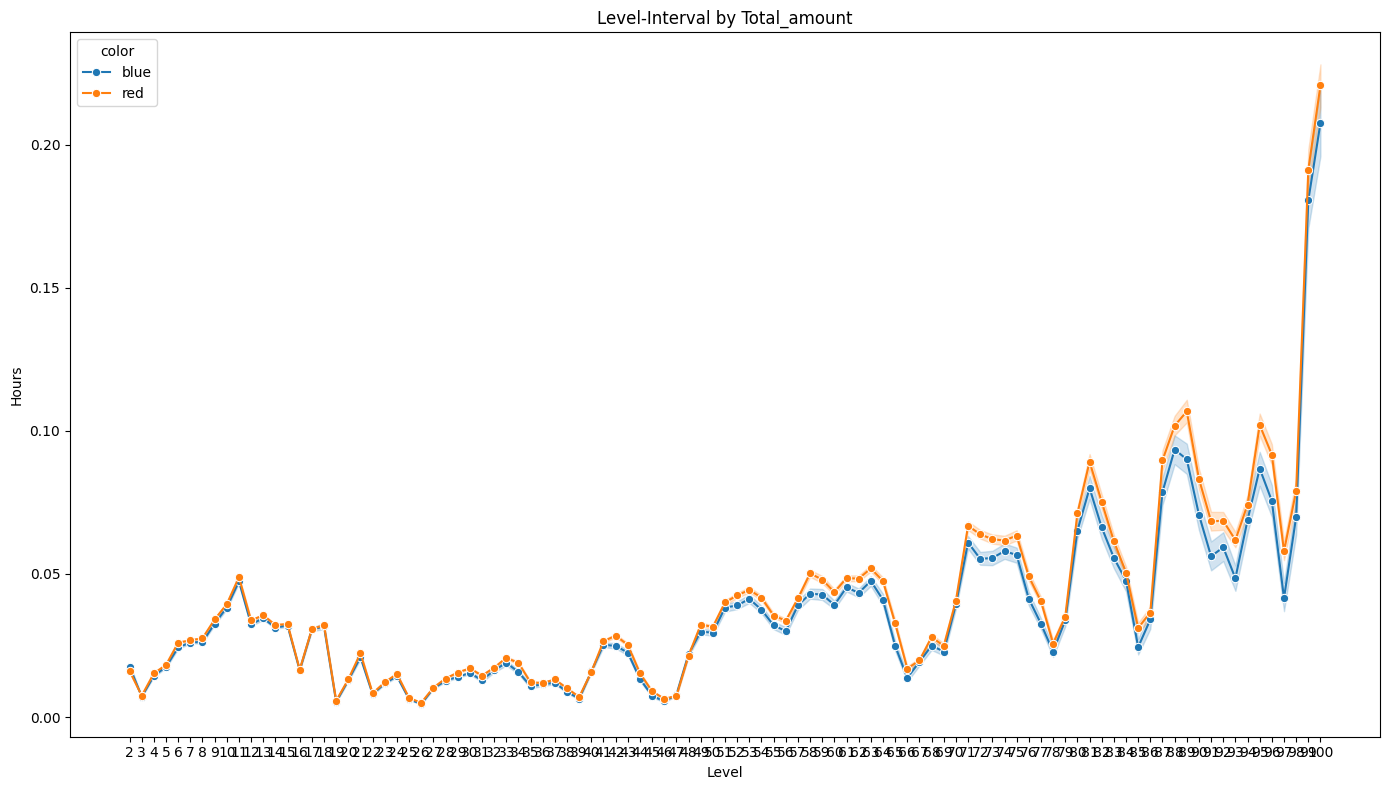

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# 플롯 생성
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_data_reset, x='level_to', y='interval', hue='color', marker='o', legend=True)

# 플롯 커스터마이징
plt.title('Level-Interval by Total_amount')
plt.xlabel('Level')
plt.ylabel('Hours')

# 플롯 표시
plt.tight_layout()
plt.show()

In [134]:
import pandas as pd
from skfda.representation.basis import FourierBasis
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother

# Load the data
file_path = 'full_lv100_0801_total_amount.csv'
data = pd.read_csv(file_path)

# Preprocessing: Removing non-numeric columns and focusing on the time-series data
time_series_data = data.drop(columns=['player_slug', 'total_amount'])

# Define the number of points (e.g., corresponding to each column index as time points)
time_points = list(time_series_data.columns.astype(float))

# Convert the time-series data into a functional data object using FDataGrid
fd = FDataGrid(data_matrix=time_series_data.to_numpy(), grid_points=time_points)

# Set up a range for the number of basis functions to test
basis_range = range(5, 51, 5)

# Dictionary to store the sum of squared errors (SSE) for different basis numbers
sse_results = {}

# Evaluate the SSE for each number of basis functions
for n_basis in basis_range:
    # Define a Fourier basis with n_basis functions
    basis = FourierBasis(n_basis=n_basis, domain_range=(min(time_points), max(time_points)))
    
    # Smoothing with basis functions
    smoother = BasisSmoother(basis=basis)
    fd_smooth = smoother.fit_transform(fd)
    
    # Calculate the residual sum of squares (SSE)
    residuals = fd - fd_smooth
    sse = (residuals.data_matrix ** 2).sum()
    
    # Store the result
    sse_results[n_basis] = sse

print(sse_results)


{5: 2900.091321350912, 10: 2504.7261276262416, 15: 2343.456101140029, 20: 2094.1022789754743, 25: 1924.06130406805, 30: 1750.0918365715938, 35: 1607.2653234568565, 40: 1457.5201654530265, 45: 1363.2284370763996, 50: 1217.0597015488077}


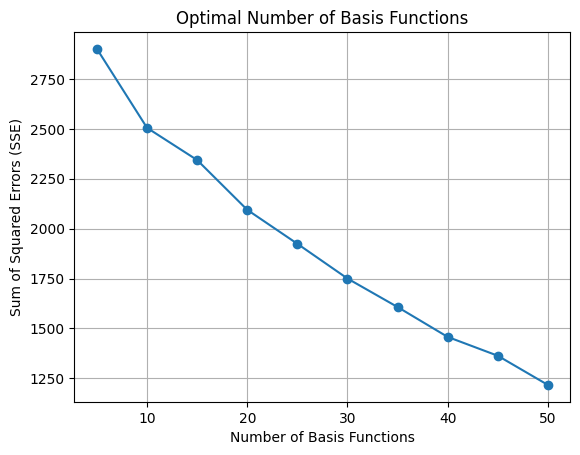

In [135]:
import matplotlib.pyplot as plt

plt.plot(list(sse_results.keys()), list(sse_results.values()), marker='o')
plt.xlabel('Number of Basis Functions')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Optimal Number of Basis Functions')
plt.grid(True)
plt.show()


In [215]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from sklearn.linear_model import LinearRegression

# 데이터 불러오기 및 전처리
file_path = 'full_lv100_0801_total_amount.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['player_slug'])

# X (타임라인 데이터)와 y (total_amount) 분리
y = data['total_amount'].values
X = data.drop(columns=['total_amount'])

# 함수형 데이터 객체 생성
argvals = np.arange(X.shape[1])
fd = FDataGrid(data_matrix=X.values, grid_points=argvals)

# 최적의 n_basis 찾기 위한 범위 설정
n_basis_options = range(5, 21)  # 예시로 5부터 20까지 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-겹 교차 검증 설정

mse_scores = []

# 각 n_basis 값에 대해 교차 검증을 수행
for n_basis in n_basis_options:
    basis = BSplineBasis(n_basis=n_basis)
    smoother = BasisSmoother(basis=basis)
    fd_smooth = smoother.fit_transform(fd)
    
    mse_fold = []
    
    for train_index, test_index in kf.split(fd_smooth):
        X_train, X_test = fd_smooth[train_index], fd_smooth[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fpca = FPCA(n_components=3)  # 예시로 5개의 주성분 사용
        fpca.fit(X_train)
        
        X_train_fpca = fpca.transform(X_train)
        X_test_fpca = fpca.transform(X_test)
        
        model = LinearRegression()
        model.fit(X_train_fpca, y_train)
        y_pred = model.predict(X_test_fpca)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_fold.append(mse)
    
    mse_scores.append(np.mean(mse_fold))

# 최적의 n_basis 선택
optimal_n_basis = n_basis_options[np.argmin(mse_scores)]

print(f"Optimal number of B-spline basis functions: {optimal_n_basis}")


Optimal number of B-spline basis functions: 20


In [153]:
r2 = r2_score(y, y_pred)

# 회귀 계수 및 R-squared 출력
print(f"R-squared: {r2}")
print(f"Coefficients: {model.coef_}")

R-squared: 0.0061023513152319575
Coefficients: [FDataBasis(
    basis=FourierBasis(domain_range=((0.0, 98.0),), n_basis=19, period=98.0),
    coefficients=[[-10815.34497165 -24623.62738686 -13575.6052805  -18810.40877091
       35609.67184976  36333.92261877   9767.09403735 -12943.6293113
        5011.08129343  31394.70200082  39395.31687364  40974.78748176
      -26625.02645037  10406.08665759 -38055.34512294  12648.53571025
      -38719.82491889 -47238.61618199   1689.48876849]],
    dataset_name=None,
    argument_names=(None,),
    coordinate_names=(None,),
    extrapolation=None)]


In [137]:
# KernelReg 사용하여 Local Linear Regression 추정
# var_type에서 'c'는 연속 변수를 의미합니다.
def gcv_score_llr(bw):
    model = KernelReg(endog=Y, exog=X, var_type='c', bw=[bw], reg_type='ll')
    mse = np.mean(model.gcv()[1])
    return mse

bw_values_llr = np.linspace(0.1, 20, 100)
gcv_scores_llr = [gcv_score_llr(bw) for bw in bw_values_llr]
h_opt_llr = bw_values_llr[np.argmin(gcv_scores_llr)]

print(f"The minimum GCV for LLR is achieved with h value: {h_opt_llr}")


ValueError: cannot reshape array of size 727900 into shape (7279,1)